# Trying out a simple Bollinger band trading strategy
This is to test my understanding of Boll

## Edit - changing to a Double Bollinger Band strategy

In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import seaborn as sns
import backtrader as bt
from datetime import datetime
import pandas_datareader as web

In [2]:
%matplotlib inline
sns.set()
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 18,9
pd.set_option('display.max_colwidth', -1)
pd.plotting.register_matplotlib_converters()
#plt.style.use('fivethirtyeight')

# Data ingestion

In [3]:
end = datetime.now()
start = datetime(end.year - 3, end.month , end.day)
bad = []

In [4]:
def download(ticker):
    df = web.DataReader(name= ticker,data_source='yahoo', start=start, end=end)
    return df

In [5]:
%%time
df = download('AAPL')

CPU times: user 147 ms, sys: 26.6 ms, total: 174 ms
Wall time: 1.41 s


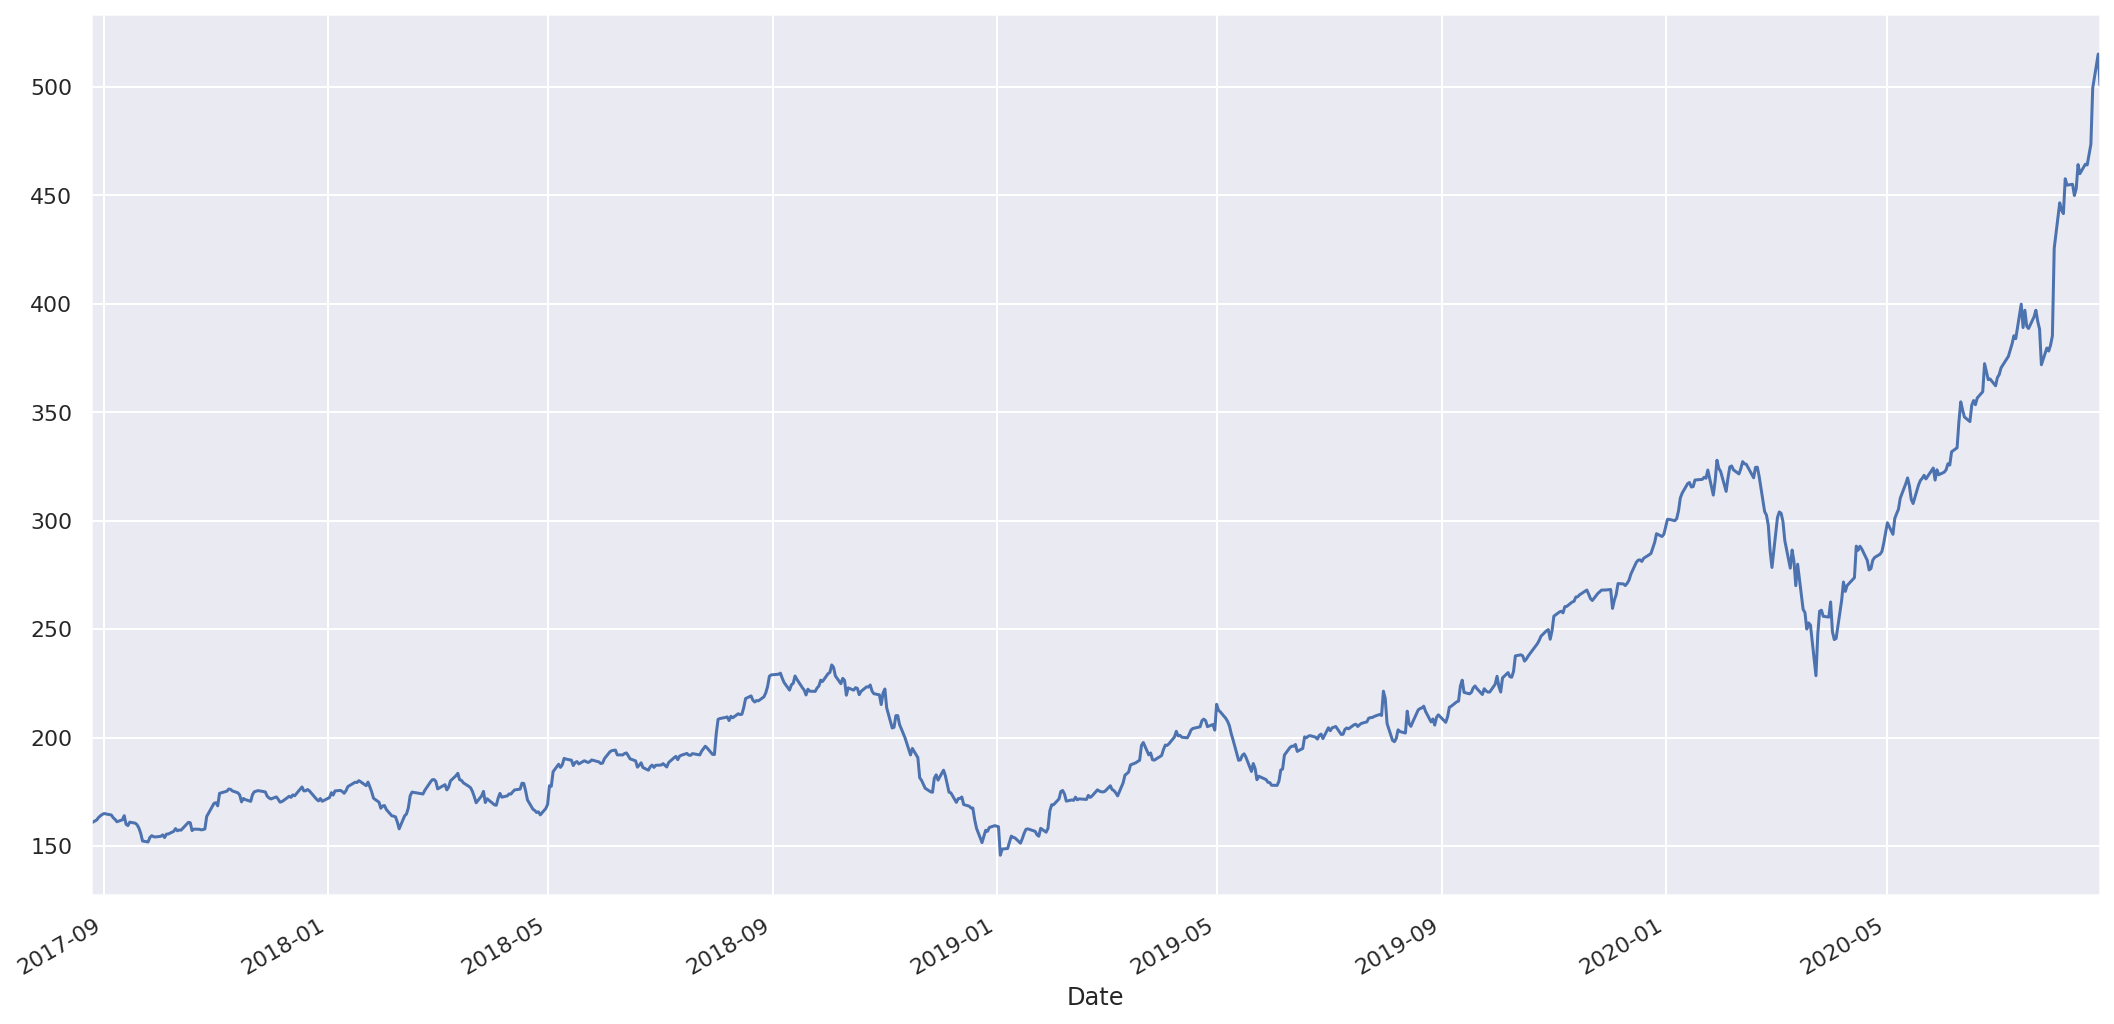

In [6]:
df['High'].plot()

In [8]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [34]:
data = bt.feeds.PandasData(dataname=df)

# Strategy definition 

In [95]:
class boll_bander(bt.Strategy):
    params = dict(
    bfast=10
    ,bslow=50
    ,dev=2.5)
    
    def __init__(self):
        self.bollf = bt.ind.BollingerBandsPct(period=self.p.bfast, plot=False)
        
        self.bollslow = bt.ind.BollingerBandsPct(period=self.p.bslow, devfactor=self.p.dev)
        
        self.buysig = bt.indicators.CrossOver(self.data0, self.bollslow.lines.bot, plotname='buy sig')
        
        self.sellsig = bt.indicators.CrossOver(self.data0, self.bollslow.lines.top,plotname='sell sig')

    def next(self):
        
        if not self.position:  # not in the market
            if self.buysig > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=1)   # enter long
                
        elif self.sellsig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position 
        

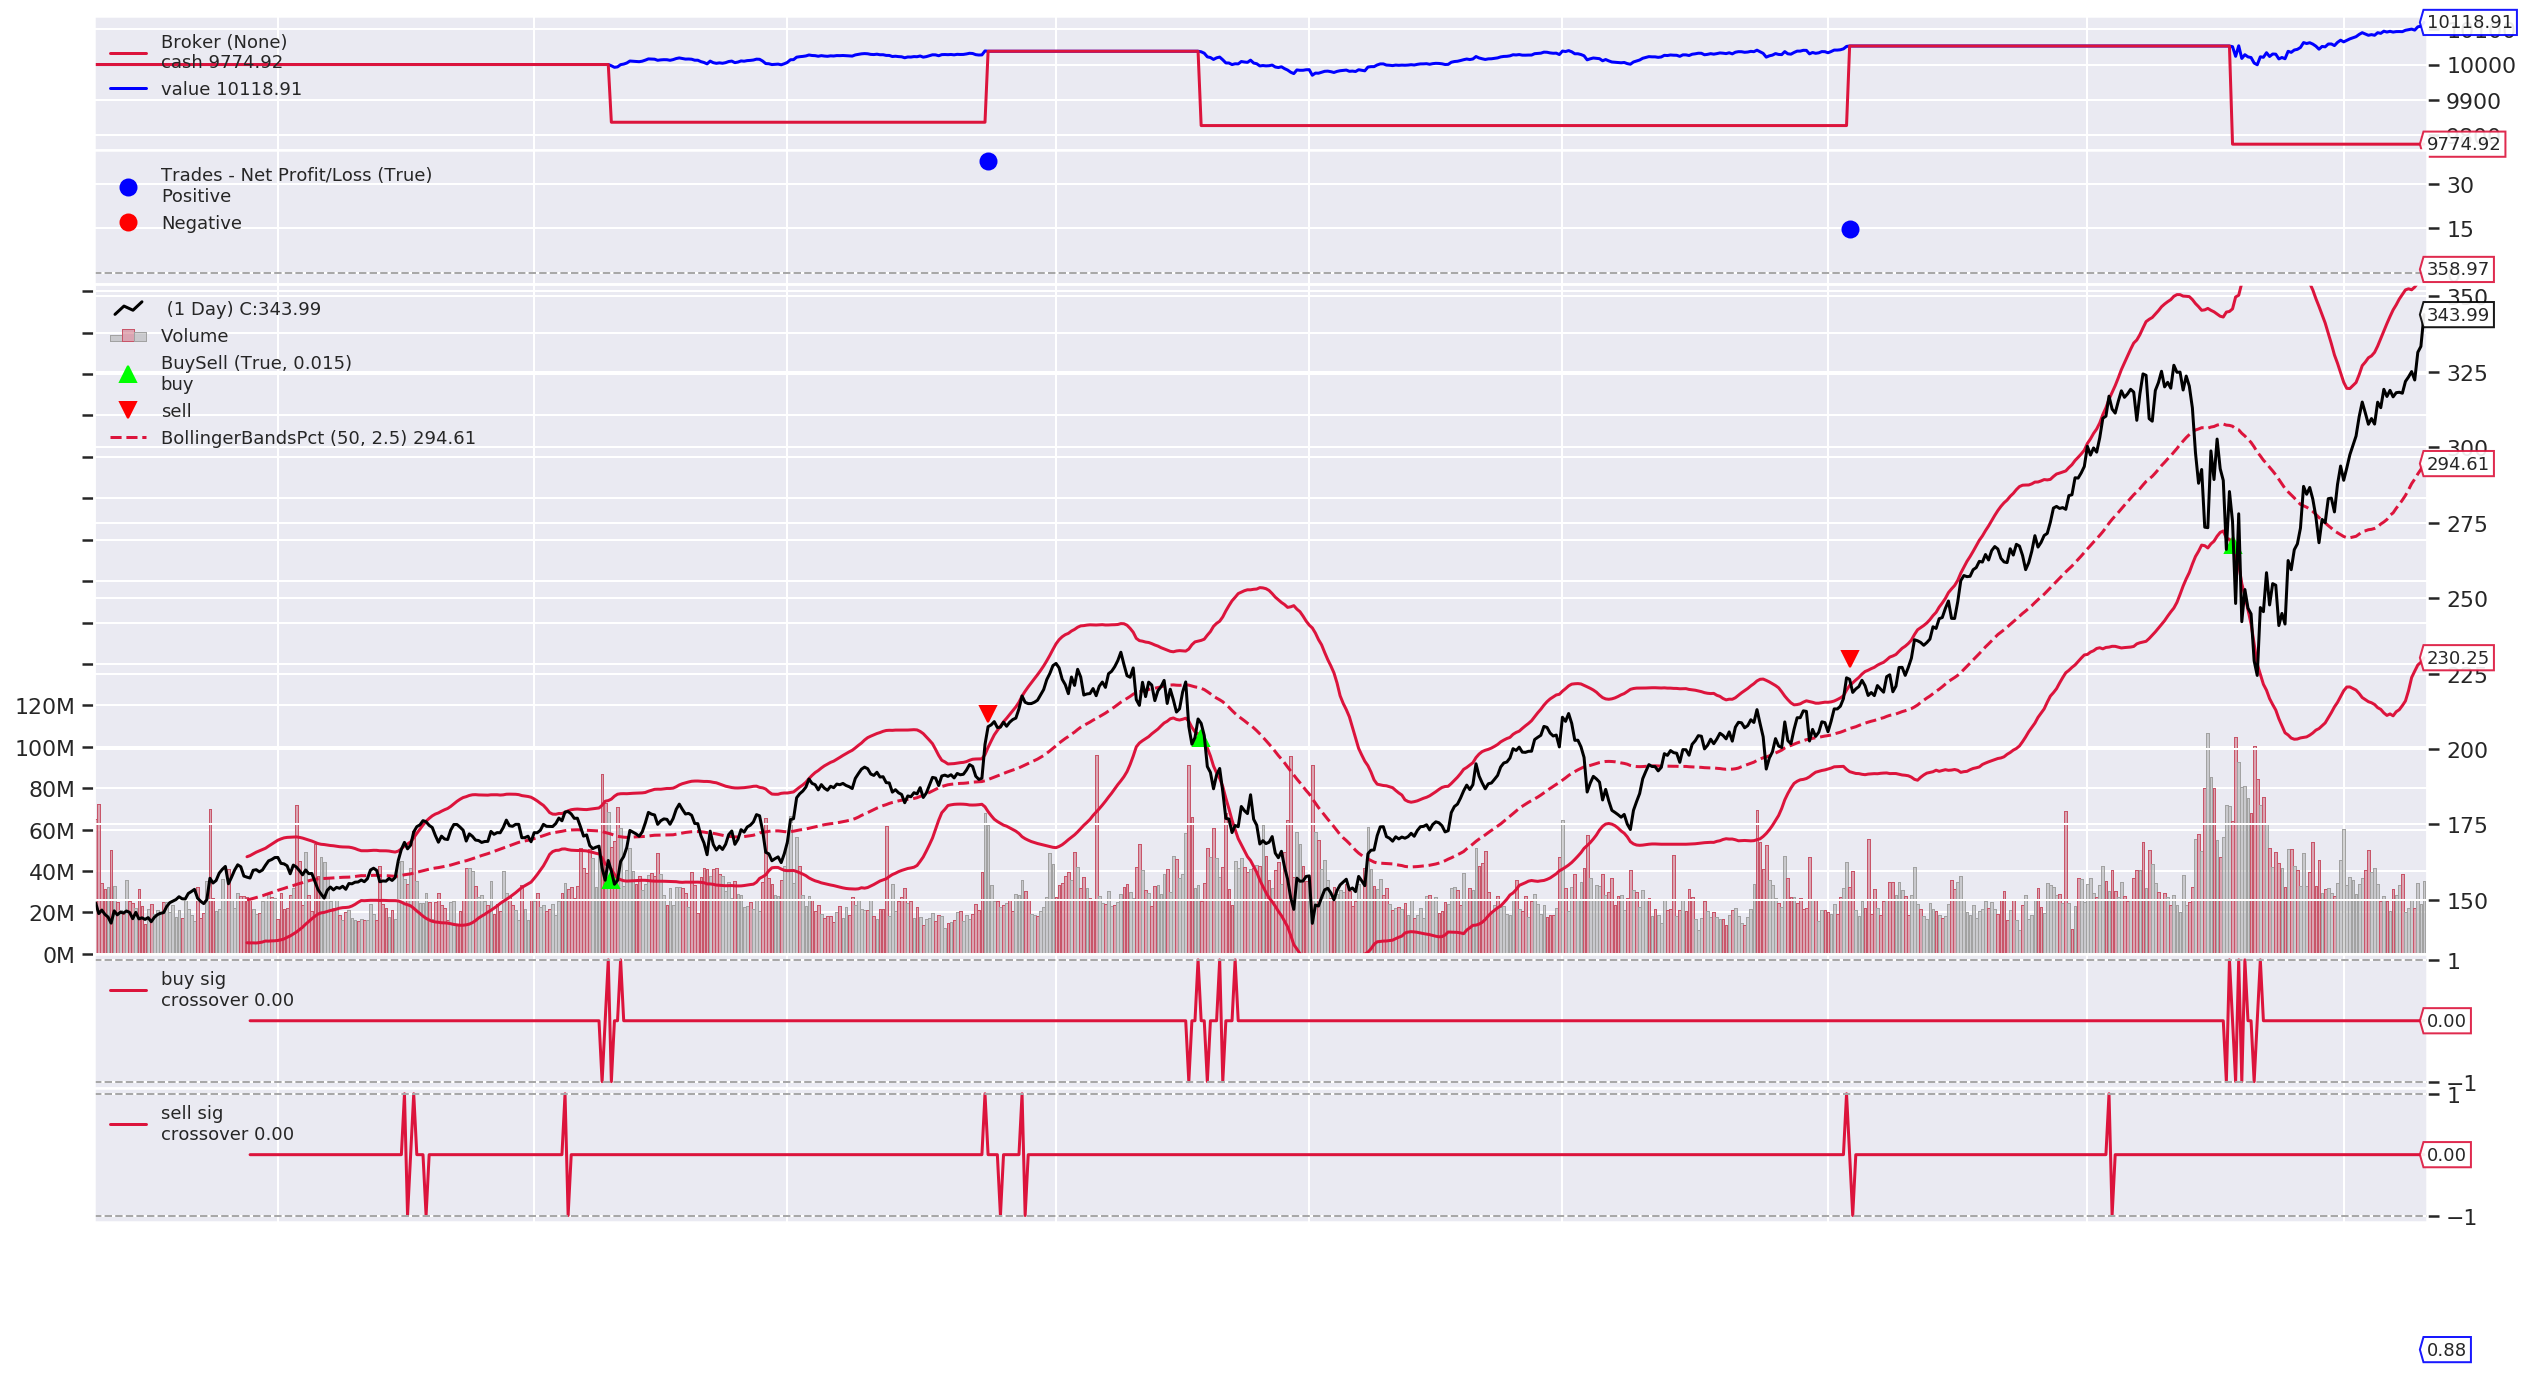

CPU times: user 2.45 s, sys: 275 ms, total: 2.73 s
Wall time: 2.31 s


[[<Figure size 1296x648 with 6 Axes>]]

In [96]:
%%time
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addstrategy(boll_bander)
results = cerebro.run()
cerebro.plot(iplot=False)

In [97]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")

Sharpe: 0.793
